<h1><center> Metapopulation Model with SIR <br><br> 
<center> NetworkX Application<br><br> 
Wendy Shi</center></center>

# Table of Content

1. [Seeding Events](#Seeding-Events)
2. [Node Dictionary](#Node-Dictionary)
3. [US Shape File](#US-Shape-File)
4. [One simulation](#One-simulation)
5. [20 Simulation](#20-Simulation)

# Preparation

In [1]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats

# Seeding Events

In [2]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
Seeding['index'] = range(len(Seeding))
print(Seeding.shape)
Seeding.head(3)

(2327, 5)


,S,E,I,R,index
0,58877,0,0,0,0
1,233140,0,0,0,1
2,25180,0,0,0,2


In [3]:
multiplier = Seeding["S"].tolist()
multiplier[:3]

[58877, 233140, 25180]

# Node Dictionary

In [4]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")
node_dict["State Code"] = node_dict["GEO_ID"].str[:2]
print(node_dict.shape)
node_dict.head(3)

(2327, 3)


,index,GEO_ID,State Code
0,0,01001,01
1,1,01003,01
2,2,01005,01


In [7]:
AZ = node_dict[node_dict["State Code"] == '04']
AZ_SEIR = pd.merge(AZ, Seeding, on = 'index', how = 'inner')
AZ_SEIR = AZ_SEIR.drop(columns=['index']) #Drop the index when merging SEIR and New York GEOID

rename = {'GEO_ID' : 'GEOID'}
AZ_SEIR = AZ_SEIR.rename(columns = rename)

print(AZ_SEIR.shape)
AZ_SEIR.head(3)

(14, 6)


,GEOID,State Code,S,E,I,R
0,04001,04,65897,0,0,0
1,04003,04,125398,0,0,0
2,04005,04,145116,0,0,0


# US Shape File

In [8]:
us_shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")

us_shape_file = us_shape_file[['NAME', 'State_1', 'FIPS code', 'pop2020']].copy()
rename = {'State_1' : 'State'}
us_shape_file = us_shape_file.rename(columns = rename)

us_shape_file["FIPS code"] = us_shape_file["FIPS code"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {"FIPS code" : "GEOID"}
us_shape_file = us_shape_file.rename(columns = rename)
us_shape_file.tail(3)

,NAME,State,GEOID,pop2020
3106,Los Angeles,California,06037,9989165.0
3107,Shannon,South Dakota,46113,14309.0
3108,Bedford,Virginia,51515,6599.0


In [12]:
AZ_name= us_shape_file[us_shape_file['State'] == "Arizona"].copy()
print(AZ_name.shape)
AZ_name.head(3)

(15, 4)


,NAME,State,GEOID,pop2020
673,Greenlee,Arizona,04011,9522.0
1118,La Paz,Arizona,04012,16580.0
1906,Graham,Arizona,04009,38614.0


In [13]:
AZ_SEIR_name = AZ_SEIR.merge(AZ_name, on = 'GEOID', how = 'left')
AZ_SEIR_list = AZ_SEIR_name['GEOID'].tolist() #The GEOID as what is appeares in the dataframe

print(AZ_SEIR_name.shape)
AZ_SEIR_name.head(3)

(14, 9)


,GEOID,State Code,S,E,I,R,NAME,State,pop2020
0,04001,04,65897,0,0,0,Apache,Arizona,65897.0
1,04003,04,125398,0,0,0,Cochise,Arizona,125398.0
2,04005,04,145116,0,0,0,Coconino,Arizona,145116.0


In [22]:
#AZ_SEIR_name.to_excel("AZ_SEIR_name.xlsx")

# Retrieve Data

In [14]:
#Original matrix for comparison
matrix = pd.read_csv("AZ_Data/Aggregate/AZ_ori_indi.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

,04001,04003,04005,04007,04009,04012,04013,04015,04017,04019,04021,04023,04025,04027
0,0.393417,0.006658,0.010795,0.002831,0.001058,0.000249,0.366134,0.005071,0.051549,0.073389,0.053571,0.002520,0.018510,0.014248
1,0.000343,0.728874,0.001962,0.001312,0.001092,0.000000,0.099431,0.000895,0.001472,0.147742,0.010781,0.005249,0.000503,0.000343
2,0.004619,0.001075,0.798236,0.004241,0.000060,0.000448,0.132651,0.003146,0.003126,0.018319,0.007397,0.000388,0.023207,0.003086


In [16]:
matrix_county_list = matrix.columns.tolist()
print(f'SEIR county list = Weight Matrix County List?: {matrix_county_list == AZ_SEIR_list}') #Proceed when see Yes

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

SEIR county list = Weight Matrix County List?: True


0.3934171229467397

# One simulation

In [17]:
def stochastic_SIR(y, l, array):
    
    # y is the list that contains the initial condition of S_i, I_i, R_i
    S = y[:l]  # a five element list
    E = y[l:l+l]
    I = y[l+l:l+l+l]  # a five element list
    R = y[l+l+l:]  # the rest elements
    
    t = 0
    time_series = [(t, S.copy(), E.copy(), I.copy(), R.copy())]
    
    #l = len(S)
    
    # Define each element of N
    N = [S[i] + E[i] + I[i] + R[i] for i in range(l)]
    
    # Define N_hat
    N_hat = [array[i][i] * N[i] for i in range(l)]
    for i in range(l):
        for j in range(l):
            if i != j:
                N_hat[i] += array[j][i] * N[j]
    
    #print(N_hat)
    
    # Run the loop ------------------------------------
    t_max = 50
    #while any(i > 0 for i in I) and t < t_max: #time stamp loop--
    while t < t_max:
        
        #Define value for beta
        if t < 25: 
            beta = 3.5
        else: 
            beta = 1.7
        
        for i in range(l): #node loop------
            
            # Define I_hat for all nodes
            I_hat = [array[i][i] * I[i] for i in range(l)]
            for j in range(l):
                if i != j:
                    I_hat[i] += array[j][i] * I[j]
            
            # Calculate lambda
            lmda = beta * (array[i][i] ** 2) * I[i] / N_hat[i]
            for j in range(l):
                if i != j:
                    lmda += (beta * array[i][i] * array[j][i] * I[j] / N_hat[i]) + (beta * array[i][j] * I_hat[j] / N_hat[j])
            
            #Newly added term, having b equals to 3.5 and largrer sample of nodes makes lamda larger than 1
            lmda_new = min(lmda,1)
            
            #Check again to see if you can improve the model-------------
            new_exposed = np.random.binomial(S[i], lmda_new)*1
            new_infected = np.random.binomial(E[i], 0.2703)*1
            new_recovered = np.random.binomial(I[i], 0.2448)*1 
            
            # Update S, I, R for node i
            S[i] -= new_exposed
            E[i] += new_exposed - new_infected
            I[i] += new_infected - new_recovered
            R[i] += new_recovered
        
        # Store the results (make copies to avoid overwriting)
        time_series.append((t, S.copy(), E.copy(), I.copy(), R.copy()))
        
        # Increment time (optional)
        t += 1
        #print(f"Time: {t}, S: {S}, I: {I}, R: {R}")
        if t % 10 == 0:
            print(t)
    
    return time_series

# Applying for the function
### This takes 3 minutes 30 second

In [23]:
#NY_SEIR = pd.read_excel("NY_SEIR.xlsx")
#NY_SEIR = NY_SEIR.drop(columns = 'Unnamed: 0')
#NY_SEIR.iloc[15:20]

In [24]:
#Define initial condition
S0 = AZ_SEIR["S"].tolist()  
E0 = AZ_SEIR["E"].tolist()  
I0 = AZ_SEIR["I"].tolist()   
R0 = AZ_SEIR["R"].tolist()
initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!
print(len(S0),len(E0),len(I0), len(R0))

14 14 14 14


In [25]:
#first simulation
time_series = stochastic_SIR(initial_conditions, 14, array)

10
20
30
40
50


In [26]:
times, S_values, E_values, I_values, R_values = zip(*time_series)

S_list = list(zip(*S_values))
for i, S in enumerate(S_list):
    globals()[f'S{i}'] = S
    
E_list = list(zip(*E_values))
for i, E in enumerate(E_list):
    globals()[f'E{i}'] = E
    
I_list = list(zip(*I_values))
for i, I in enumerate(I_list):
    globals()[f'I{i}'] = I
    
R_list = list(zip(*R_values))
for i, R in enumerate(R_list):
    globals()[f'R{i}'] = R

<br>

- **globals()** is a built-in function in Python that returns a dictionary representing the current global symbol table. The global symbol table contains all the global variables in the program. When you do globals()[f'S{i}'] = s, you're dynamically creating a new global variable with a name like S1, S2, etc., and assigning it the value s. In this case, f'S{i}' generates the variable name as a string, and s is the corresponding value from the list.

<br>

- **enumerate()** is a built-in Python function that allows you to loop over an iterable (like a list, tuple, or string) while also keeping track of the index of each element.When used like enumerate(S_list, start=1), it returns pairs of (index, value), where index starts at 1 and increases by 1 for each iteration, while value is the corresponding item from the list. The start=1 parameter means that the counting will begin at 1 instead of the default 0.

# Visualization: One Loop

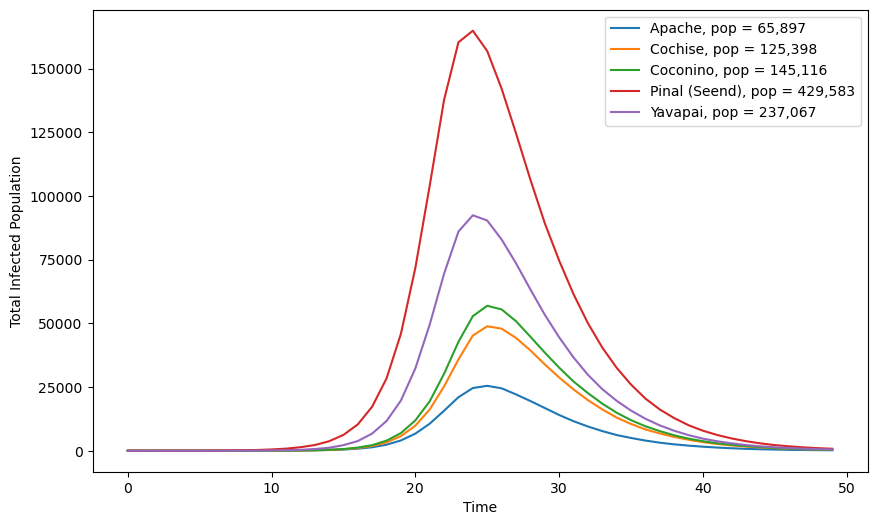

In [30]:
plt.figure(figsize=(10,6))

plt.plot(times, I0, label='Apache, pop = 65,897')
plt.plot(times, I1, label='Cochise, pop = 125,398')
plt.plot(times, I2, label='Coconino, pop = 145,116')
plt.plot(times, I10, label='Pinal (Seend), pop = 429,583')
plt.plot(times, I12, label='Yavapai, pop = 237,067')

plt.xlabel('Time')
plt.ylabel('Total Infected Population')
plt.legend()
#plt.savefig("CA_SEIR_Example.png", dpi=300, bbox_inches='tight')

plt.show()



# 20 Simulation

In [84]:
matrix = pd.read_csv("AZ_Data/Individual/AZ_P005_indi.csv")
matrix = matrix.drop(columns = 'Unnamed: 0')
matrix.head(3)

array = matrix.to_numpy() #The most important step!! Turning pandas dataframe to a numpy array
array[0][0]

0.2626928210062386

In [85]:
all_simulations = []

for sim in range(20):
    
    S0 = WA_SEIR["S"].tolist()  
    E0 = WA_SEIR["E"].tolist()  
    I0 = WA_SEIR["I"].tolist()   
    R0 = WA_SEIR["R"].tolist()
    initial_conditions = S0 + E0 + I0 + R0 #this is the y (?): Yup!

    result = stochastic_SIR(initial_conditions, 14, array)
    print("Simulation", sim, "Finished!!!-------------------------------")
    
    all_simulations.append(result)

10
20
30
40
50
Simulation 0 Finished!!!-------------------------------
10
20
30
40
50
Simulation 1 Finished!!!-------------------------------
10
20
30
40
50
Simulation 2 Finished!!!-------------------------------
10
20
30
40
50
Simulation 3 Finished!!!-------------------------------
10
20
30
40
50
Simulation 4 Finished!!!-------------------------------
10
20
30
40
50
Simulation 5 Finished!!!-------------------------------
10
20
30
40
50
Simulation 6 Finished!!!-------------------------------
10
20
30
40
50
Simulation 7 Finished!!!-------------------------------
10
20
30
40
50
Simulation 8 Finished!!!-------------------------------
10
20
30
40
50
Simulation 9 Finished!!!-------------------------------
10
20
30
40
50
Simulation 10 Finished!!!-------------------------------
10
20
30
40
50
Simulation 11 Finished!!!-------------------------------
10
20
30
40
50
Simulation 12 Finished!!!-------------------------------
10
20
30
40
50
Simulation 13 Finished!!!-------------------------------
10

In [82]:
import pickle

with open('20_simulations_P005_AZ_indi.pkl', 'wb') as f:
    pickle.dump(all_simulations, f)